# Suivi de l'épidémie de COVID-19 basé sur les données de Santé Publique France

Source des données:
- Santé Publique France: https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/#_
- Eco-Santé (IRDES, DREES, CNAMTS): http://www.ecosante.fr/index2.php?base=DEPA&langs=FRA&langh=FRA&source=800341


In [1]:
MES_DEPARTEMENTS_FAVORIS = ['31']
COLONNES = ['hospitalisation', 'réanimation', 'décès']
LISSAGE = 3 # en jours (1 jour = pas de lissage)

In [2]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Charge les dernière données CSV de Santé Publique France dans une table Pandas

df = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7', sep=';') \
       .rename(columns=dict(dep='département', 
                            hosp='hospitalisation', 
                            rea='réanimation', 
                            rad='radiation', 
                            dc='décès'))
df['jour'] = pd.to_datetime(df['jour'])
df.sort_values('jour', inplace=True)
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62724 entries, 0 to 62723
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   département      62721 non-null  object        
 1   sexe             62724 non-null  int64         
 2   jour             62724 non-null  datetime64[ns]
 3   hospitalisation  62724 non-null  int64         
 4   réanimation      62724 non-null  int64         
 5   radiation        62724 non-null  int64         
 6   décès            62724 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 3.8+ MB
None


,département,sexe,jour,hospitalisation,réanimation,radiation,décès
62518,32,1,2020-10-10,7,1,53,17
62517,32,0,2020-10-10,11,1,102,29
62516,31,2,2020-10-10,64,10,490,50
62523,34,0,2020-10-10,155,49,1009,155
62723,976,2,2020-10-10,1,0,241,11


Evolution nationale depuis Mars 2020


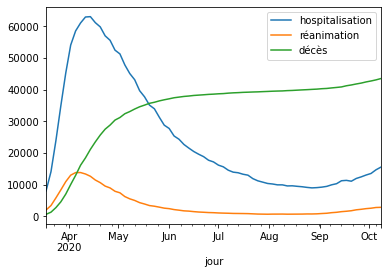

In [4]:
# Affiche l'évolution nationale des colonnes hospitalisation, réanimation et décès
# sur tout l'historique disponible

df.groupby('jour')[COLONNES]      \
  .sum()                          \
  .resample(rule='%dD' % LISSAGE) \
  .mean()                         \
  .plot()
print('Evolution nationale depuis Mars 2020')
plt.show()

Evolution depuis Mars 2020 dans les 10 départements avec le plus haut pic d'hospitalisations + les départements favoris


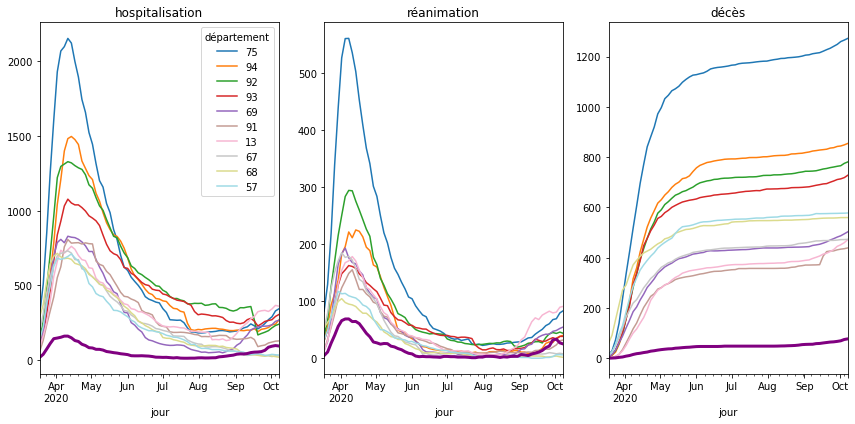

In [5]:
# Affiche l'évolution des hospitalisations, réanimations et des décès 
# pour les 10 départements qui ont le plus haut pic d'hospitalisation
# plus les départements favoris sur tout l'historique disponible

topdf = df.pivot_table(index='jour', columns='département', values='hospitalisation')
top10 = list(topdf.max().sort_values(ascending=False).index[:10])

plt.figure(figsize=(12, 6))
for i, colonne in enumerate(COLONNES):
    ax = plt.subplot(1,len(COLONNES), i+1)
    plotdf = df.pivot_table(index='jour', 
                            columns='département', 
                            values=colonne)    \
               .resample(rule='%dD' % LISSAGE) \
               .mean()
    if i == 0:
        legend = True
    else:
        legend = False
    plotdf[top10].plot(ax=ax, legend=legend, cmap='tab20')
    plotdf['31'].plot(ax=ax, color='purple', linewidth=3)
    ax.set_title(colonne)
plt.tight_layout()
print('Evolution depuis Mars 2020 dans les 10 départements avec le plus haut pic d\'hospitalisations + les départements favoris')
plt.show()

In [6]:
# Filtre l'historique sur le dernier mois

subdf = df[df['jour'] > df['jour'].max() - pd.DateOffset(months=1)]

Evolution nationale le mois dernier


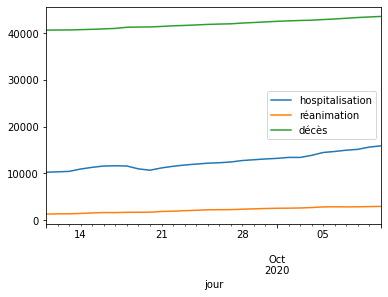

In [7]:
# Affiche l'évolution nationale des colonnes hospitalisation, réanimation et décès
# sur le mois dernier

subdf.groupby('jour')[COLONNES] \
     .sum()                     \
     .plot()
print('Evolution nationale le mois dernier')
plt.show()

Evolution le mois dernier dans les 10 départements avec le plus de réanimations + les départements favoris


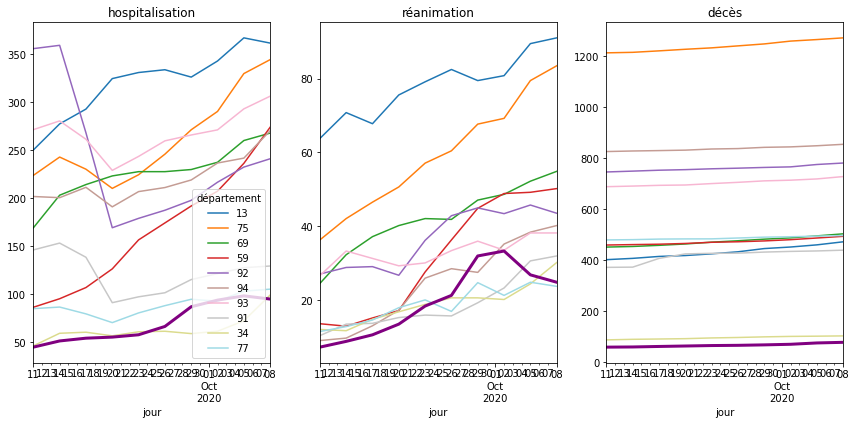

In [8]:
# Affiche l'évolution des hospitalisations, réanimations et des décès 
# pour les 10 départements qui ont le plus de réanimations
# plus les départements favoris sur le mois dernier

topdf = subdf.pivot_table(index='jour', columns='département', values='réanimation')
top10 = list(topdf.iloc[-1].sort_values(ascending=False).index[:10])

plt.figure(figsize=(12, 6))
for i, colonne in enumerate(COLONNES):
    ax = plt.subplot(1,len(COLONNES), i+1)
    plotdf = subdf.pivot_table(index='jour',
                               columns='département', 
                               values=colonne)    \
                  .resample(rule='%dD' % LISSAGE) \
                  .mean()
    if i == 0:
        legend = True
    else:
        legend = False
    plotdf[top10].plot(ax=ax, legend=legend, cmap='tab20')
    plotdf['31'].plot(ax=ax, color='purple', linewidth=3)
    ax.set_title(colonne)
plt.tight_layout()
print('Evolution le mois dernier dans les 10 départements avec le plus de réanimations + les départements favoris')
plt.show()

In [9]:
# Chargement des données du recensement de 2015 dans une table Pandas

popdf = pd.read_csv('population_par_departement.2015.csv', 
                    encoding='latin1', 
                    sep=';', 
                    skiprows=7,
                    skipfooter=5,
                    names=['departement', 'population', 'foo', 'bar'],
                    usecols=['departement', 'population'])
popdf['id'] = popdf['departement'].str.slice(0, 3)
popdf = popdf[popdf['id'].str.startswith('D')]
popdf['id'] = popdf['id'].str.slice(1, 3)
popdf['id'].iloc[-5:] = df['département'].sort_values().dropna().unique()[-5:]
popdf['population'].iloc[:-5] = popdf['population'].iloc[:-5].str.slice(0, -1)
popdf['population'] = popdf['population'].astype(int)
popdf.set_index('id', inplace=True)
print(popdf.info())
print('Population totale: %d habitants...' % popdf['population'].sum())
popdf

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 01 to 976
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   departement  101 non-null    object
 1   population   101 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None
Population totale: 66380602 habitants...


<ipython-input-9-b6870b382736>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  popdf = pd.read_csv('population_par_departement.2015.csv',


,departement,population
id,,
01,D01 Ain,634173
02,D02 Aisne,538743
03,D03 Allier,343680
04,D04 Alpes-de-Haute-Provence,162924
05,D05 Hautes-Alpes,140706
...,...,...
971,D9A Guadeloupe,400132
972,D9B Martinique,378243
973,D9C Guyane,254541


In [10]:
# Jointure entre les données du COVID-19 et celles du recensement

df = df.join(popdf, on=['département'])
df

,département,sexe,jour,hospitalisation,réanimation,radiation,décès,departement,population
0,01,0,2020-03-18,2,0,1,0,D01 Ain,634173.0
206,68,2,2020-03-18,164,27,47,35,D68 Haut-Rhin,763716.0
205,68,1,2020-03-18,203,50,67,38,D68 Haut-Rhin,763716.0
204,68,0,2020-03-18,371,77,116,74,D68 Haut-Rhin,763716.0
203,67,2,2020-03-18,99,21,1,8,D67 Bas-Rhin,1118009.0
...,...,...,...,...,...,...,...,...,...
62518,32,1,2020-10-10,7,1,53,17,D32 Gers,191639.0
62517,32,0,2020-10-10,11,1,102,29,D32 Gers,191639.0
62516,31,2,2020-10-10,64,10,490,50,D31 Haute-Garonne,1335366.0
62523,34,0,2020-10-10,155,49,1009,155,D34 Hérault,1123990.0


Evolution depuis Mars 2020 dans les 10 départements avec le plus de décès par rapport au nombre d'habitants + les départements favoris


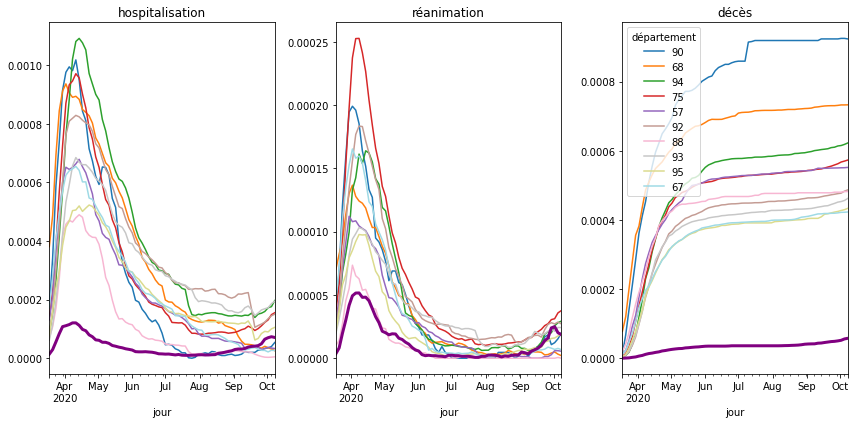

In [11]:
# Affiche l'évolution des hospitalisations, réanimations et des décès
# relative au nombre d'habitants
# pour les 10 départements qui ont le plus haut pic de décès
# plus les départements favoris sur tout l'historique disponible

df['décès_norm'] = df['décès'] / df['population']
topdf = df.pivot_table(index='jour', columns='département', values='décès_norm')
top10 = list(topdf.max().sort_values(ascending=False).index[:10])


plt.figure(figsize=(12, 6))
for i, colonne in enumerate(COLONNES):
    ax = plt.subplot(1,len(COLONNES), i+1)
    df['%s_norm' % colonne] = df[colonne] / df['population']
    plotdf = df.pivot_table(index='jour', 
                            columns='département', 
                            values='%s_norm' % colonne) \
               .resample(rule='%dD' % LISSAGE)          \
               .mean()
    if i == 2:
        legend = True
    else:
        legend = False
    plotdf[top10].plot(ax=ax, legend=legend, cmap='tab20')
    plotdf['31'].plot(ax=ax, color='purple', linewidth=3)
    ax.set_title(colonne)
plt.tight_layout()
print('Evolution depuis Mars 2020 dans les 10 départements avec le plus de décès par rapport au nombre d\'habitants + les départements favoris')
plt.show()

In [12]:
# Filtre l'historique sur le dernier mois

subdf = df[df['jour'] > df['jour'].max() - pd.DateOffset(months=1)]

<ipython-input-13-b459916af02b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['réanimation_norm'] = subdf['réanimation'] / subdf['population']
<ipython-input-13-b459916af02b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['%s_norm' % colonne] = subdf[colonne] / subdf['population']
<ipython-input-13-b459916af02b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Evolution le mois dernier dans les 10 départements avec le plus de réanimations par rapport au nombre d'habitants + les départements favoris


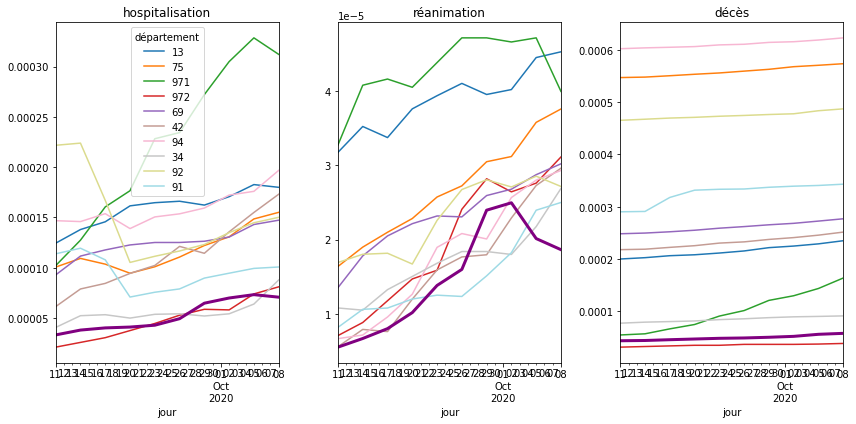

In [13]:
# Affiche l'évolution des hospitalisations, réanimations et des décès
# relative au nombre d'habitants
# pour les 10 départements qui ont le plus de réanimations par rapport au nombre d'habitants
# plus les départements favoris sur tout l'historique disponible

subdf['réanimation_norm'] = subdf['réanimation'] / subdf['population']
topdf = subdf.pivot_table(index='jour', columns='département', values='réanimation_norm')
top10 = list(topdf.iloc[-1].sort_values(ascending=False).index[:10])

plt.figure(figsize=(12, 6))
for i, colonne in enumerate(COLONNES):
    ax = plt.subplot(1,len(COLONNES), i+1)
    subdf['%s_norm' % colonne] = subdf[colonne] / subdf['population']
    plotdf = subdf.pivot_table(index='jour', 
                               columns='département', 
                               values='%s_norm' % colonne) \
                  .resample(rule='%dD' % LISSAGE)          \
                  .mean()
    if i == 0:
        legend = True
    else:
        legend = False
    plotdf[top10].plot(ax=ax, legend=legend, cmap='tab20')
    plotdf['31'].plot(ax=ax, color='purple', linewidth=3)
    ax.set_title(colonne)
    
plt.tight_layout()
print('Evolution le mois dernier dans les 10 départements avec le plus de réanimations par rapport au nombre d\'habitants + les départements favoris')
plt.show()